In [2]:
BATCH_SIZE = 64
EMB_SIZE = 128 # Уменьшу занимаемую память для бейзлайна
K_NEIGHBORS = 5
EPOCHS = 5

In [3]:
!pip install pytorch-metric-learning
!pip install faiss-cpu
!pip install albumentations
!pip install torchinfo
!pip install pytorch-lightning
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 3.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 57.4 MB/s eta 0:00:00:00:0100:01


In [4]:
import numpy as np
import pandas as pd
import os
import yaml
import shutil
import glob
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pytorch_lightning as L
from pytorch_lightning.loggers import WandbLogger

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning import distances, losses, miners, reducers, testers, samplers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import faiss

from torchinfo import summary

from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

from kaggle_secrets import UserSecretsClient

import wandb

import warnings

warnings.warn("deprecated", DeprecationWarning)

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-4-de6c0c8db1bf>:41: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


In [5]:
user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

In [6]:
dataset_dir = "/kaggle/input/logodet3k/LogoDet-3K"
os.listdir(dataset_dir)

['Leisure',
 'Sports',
 'Necessities',
 'Medical',
 'Electronic',
 'Clothes',
 'Transportation',
 'Food',
 'Others']

In [7]:
df = pd.DataFrame(glob.glob(f"{dataset_dir}/*/*/*"), columns=["file_path"])
df["ext"] = df["file_path"].apply(lambda x: x.split(".")[-1])
df["logo_category"] = df["file_path"].apply(lambda x: x.split(os.sep)[-3])
df["logo_name"] = df["file_path"].apply(lambda x: x.split(os.sep)[-2])
df.head()


,file_path,ext,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


In [8]:
df.to_csv("logodet3k_reference.csv", index=False)

Данных довольно много, а сдавать тестовое нужно через 5 часов...
Возможно придётся выбрать только одну категорию для работы

In [9]:
df["ext"].value_counts()

ext
jpg    158654
xml    158654
Name: count, dtype: int64

In [10]:
df2 = df[df["ext"]=="jpg"].iloc[:]
print({
    "No. of categories": df2["logo_category"].nunique(), 
    "No. of logo types": df2["logo_name"].nunique(),
    "Avg. no. of images per category": df2.groupby("logo_category")["file_path"].count().mean().round(), 
    "Avg. no. of images per logo": df2.groupby("logo_name")["file_path"].count().mean().round(), 
})

{'No. of categories': 9, 'No. of logo types': 3000, 'Avg. no. of images per category': 17628.0, 'Avg. no. of images per logo': 53.0}


In [11]:
df2["logo_category"].value_counts()

logo_category
Food              53350
Clothes           31266
Necessities       24822
Others            15513
Transportation    10445
Electronic         9675
Leisure            5685
Sports             3953
Medical            3945
Name: count, dtype: int64

Явный дисбаланс классов. Стоит учесть это в метриках. Возможно стоит 

In [12]:
labels_unique = df2["logo_name"].unique()
num_classes = len(labels_unique)
num_classes

3000

<Axes: title={'center': 'Distribution of logo img counts'}, xlabel='logo_name'>

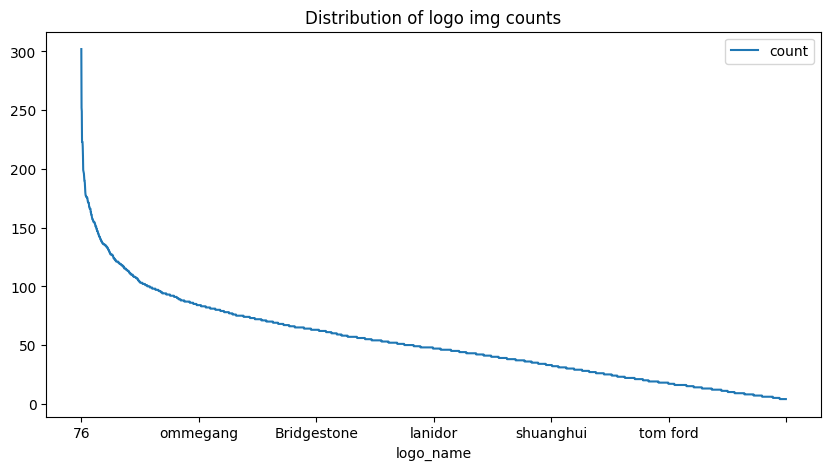

In [13]:
df2["logo_name"].value_counts().reset_index().plot(
    x="logo_name", y="count", figsize=(10,5), title="Distribution of logo img counts")

In [14]:
dataset_dst_dir = "/kaggle/working/logodet3k"
if os.path.exists(dataset_dst_dir):
    shutil.rmtree(dataset_dst_dir)
os.makedirs(f"{dataset_dst_dir}/train", exist_ok=True)
os.makedirs(f"{dataset_dst_dir}/val", exist_ok=True)

# Mapping unique logo names to class indices
classname2idx = {logo_name: idx for idx, logo_name in enumerate(sorted(df2["logo_name"].unique()))}
print(str(classname2idx)[:100] + "...")

# This ensures each logo has a unique ID
idx2classname = {idx: logo_name for logo_name, idx in classname2idx.items()}

# classname2idx = {"logo": 0}
# idx2classname = defaultdict(lambda: "logo")

class_name_idx_map_str = "\n".join([f"    {idx}: {class_name}" for class_name, idx in classname2idx.items()])
# print(class_name_idx_map_str)

dataset_config = f"""
path: {dataset_dst_dir} 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
{class_name_idx_map_str}
"""

with open("dataset_config.yaml", "w") as f:
    f.write(dataset_config)
with open("dataset_config.yaml", "r") as f:
    datcon = yaml.safe_load(f)

{'10 Cane': 0, '1519 Tequila': 1, '241 Pizza': 2, '2XU': 3, '2xist': 4, '3D-GOLD': 5, '3nod': 6, '3t...


In [15]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=15, p=0.25),
    A.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05, p=0.5),
    A.Equalize(p=0.25),
    A.Perspective(scale=(0.8, 1.2), p=0.25),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [16]:
class LogoDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_mapping=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing file paths and labels.
            transform: Albumentations transform pipeline.
            class_mapping (dict): Mapping from logo names to class indices.
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.class_mapping = class_mapping

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the row from the dataframe
        row = self.dataframe.iloc[idx]
        file_path = row["file_path"]

        # Read the image using OpenCV
        image = cv2.imread(file_path)
        if image is None:
            raise ValueError(f"Image not found: {file_path}")
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get the label using the mapping dictionary and convert it to a tensor
        label = self.class_mapping[row["logo_name"]]
        label = torch.tensor(label, dtype=torch.long)
        
        # Apply augmentations if provided
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        else:
            # If no transform, manually convert to tensor and permute dimensions
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        
        return image, label


In [17]:
train_df, val_df = train_test_split(df2, test_size=0.2, random_state=42, stratify=df2["logo_name"])

In [18]:
# sampler preventing the model from favoring majority classes.
sampler = samplers.MPerClassSampler(labels_unique, m=BATCH_SIZE//4, batch_size=BATCH_SIZE)

In [19]:
train_dataset = LogoDataset(dataframe=train_df, transform=train_transform, class_mapping=classname2idx)
val_dataset   = LogoDataset(dataframe=val_df, transform=test_transform, class_mapping=classname2idx)


In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, persistent_workers=True)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, persistent_workers=True)

Проверю, что всё работает

huarun


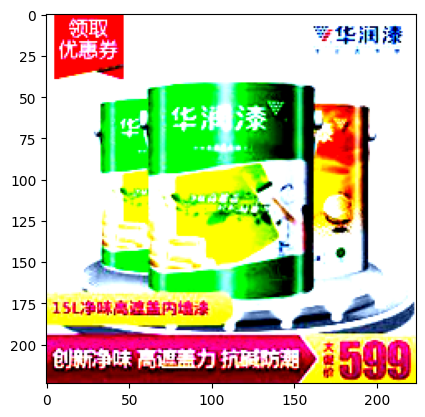

In [21]:
for image, label in train_dataset:
        print(idx2classname[label.item()])
        plt.imshow(image.permute(1, 2, 0))
        plt.show()

        break

Training Model

In [22]:
def get_model():
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[2] = nn.Linear(in_features=768, out_features=EMB_SIZE, bias=False)

    return model

In [23]:
trained_model = get_model()

summary(model=trained_model,
        input_size=(1, 3, 224, 224),  #[batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 68.4MB/s] 


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [1, 3, 224, 224]     [1, 128]             --                   Partial
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 768, 7, 7]       --                   False
│    └─Conv2dNormActivation (0)                         [1, 3, 224, 224]     [1, 96, 56, 56]      --                   False
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 96, 56, 56]      (4,704)              False
│    │    └─LayerNorm2d (1)                             [1, 96, 56, 56]      [1, 96, 56, 56]      (192)                False
│    └─Sequential (1)                                   [1, 96, 56, 56]      [1, 96, 56, 56]      --                   False
│    │    └─CNBlock (0)                                 [1, 96, 56, 56]      [1, 96, 56, 56]      (79,296)             

In [24]:
import torch
import numpy as np
import faiss

class PMLMetricWrapper:
    def __init__(self, k=5):
        self.embedding_dim = EMB_SIZE
        self.k = K_NEIGHBORS
        self.reset()
        
    def compute(self):
        """
        Compute both Top-1 Accuracy and mean Average Precision (mAP).
        """
        if self.embeddings.size(0) == 0:
            return {"top1_accuracy": 0.0, "mean_average_precision": 0.0}

        if self.embedding_dim is None:
            raise ValueError("Embedding dimension is not set. Did you update the wrapper with valid embeddings?")

        embeddings_np = self.embeddings.numpy().astype('float32')
        labels_np = self.labels.numpy().astype('int64')

        # Build FAISS index on CPU
        index = faiss.IndexFlatL2(self.embedding_dim)
        index.add(embeddings_np)

        # Search for k+1 nearest neighbors (including self, first result is always the query itself)
        distances, indices = index.search(embeddings_np, self.k + 1)

        # Compute both metrics
        top1_acc = self.compute_top1_accuracy(labels_np, indices)
        mAP = self.compute_map(labels_np, indices)

        return {"accuracy": top1_acc, "mean_average_precision": mAP}

    def compute_top1_accuracy(self, labels_np, indices):
        """
        Compute Top-1 Accuracy using kNN majority voting.
        """
        correct = 0
        for i in range(len(labels_np)):
            # Get labels of nearest neighbors (excluding the first one, which is the query itself)
            neighbor_labels = labels_np[indices[i][1:]]
            # Predict using majority vote
            pred = np.bincount(neighbor_labels).argmax()
            if pred == labels_np[i]:
                correct += 1
        return correct / len(labels_np)

    def compute_map(self, labels_np, indices):
        """
        Compute mean Average Precision (mAP).
        """
        average_precisions = []
        
        for i in range(len(labels_np)):
            # Get labels of retrieved neighbors (excluding the first one, which is the query itself)
            retrieved_labels = labels_np[indices[i][1:]]
            # Determine relevance (1 if label matches query label, else 0)
            relevances = (retrieved_labels == labels_np[i]).astype(np.int32)

            # Compute precision at ranks where relevant items are found
            precisions = []
            num_relevant = 0
            for rank, rel in enumerate(relevances, start=1):
                if rel:
                    num_relevant += 1
                    precisions.append(num_relevant / rank)

            # Average precision for this query
            if precisions:
                average_precisions.append(np.mean(precisions))
            else:
                average_precisions.append(0.0)

        # Mean Average Precision over all queries
        return np.mean(average_precisions)

    def update(self, embeddings, labels):
        """
        Append new embeddings and labels.
        They are detached from the GPU and moved to CPU immediately.
        """
        if embeddings is None or labels is None or len(embeddings) == 0 or len(labels) == 0:
            return

        # Detach and move to CPU.
        embeddings = embeddings.detach().cpu()
        labels = labels.detach().cpu()

        # If this is the first update, just assign.
        if self.embeddings.size(0) == 0:
            self.embeddings = embeddings
            self.labels = labels
        else:
            self.embeddings = torch.cat((self.embeddings, embeddings), dim=0)
            self.labels = torch.cat((self.labels, labels), dim=0)

    def reset(self):
        # Initialize empty tensors on CPU.
        self.embeddings = torch.empty((0, self.embedding_dim))
        self.labels = torch.empty(0, dtype=torch.long)


In [25]:
class Module(L.LightningModule):
    def __init__(self, model, learning_rate, criterion, miner):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.metrics = PMLMetricWrapper()
        self.lr = learning_rate
        self.miner = miner

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        embeddings = self.model(images)
        pairs = self.miner(embeddings, target)
        loss = self.criterion(embeddings, target, indices_tuple=pairs)

        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_validation_epoch_start(self):
        self.metrics.reset()

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        if len(images) == 0:
            self.log("empty_batch", 1, logger=False)
            return
        embeddings = self.model(images).detach().cpu()
        self.metrics.update(embeddings, target.detach().cpu())

    def on_validation_epoch_end(self):
        metrics = self.metrics.compute()
        self.log("accuracy", metrics["accuracy"], prog_bar=True, logger=True)
        self.log("mAP", metrics["mean_average_precision"], prog_bar=True, logger=True)


In [26]:
model = get_model()

out = model(torch.randn(1, 3, 224, 224))
print(out.shape)

torch.Size([1, 128])


Loss object

In [27]:
criterion = TripletMarginLoss(
    margin=0.2
)

for name, p in criterion.named_parameters():
    print(name, p.shape)

In [28]:
miner = miners.MultiSimilarityMiner(epsilon=0.1)

## Training

In [29]:
wandb.login(key=WANDB_API_KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vldmrl (vldmrl-org). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [30]:
run = wandb.init(project="logo-metric-learning")

In [31]:
wandb_logger = WandbLogger(
    log_model='all',
    name='ConvNext_tiny_Triplet_baseline_5ep'
)

In [32]:
module = Module(model, 0.001, criterion, miner)

In [33]:
checkpoint_callback_trainable = L.callbacks.ModelCheckpoint(dirpath="convnext_tiny_best_weight_transfer",
                                                             save_top_k=1,
                                                             monitor="mAP",
                                                             mode="max")

In [34]:
trainer = L.Trainer(logger=wandb_logger,
                     max_epochs=EPOCHS,
                     accelerator=device,
                    callbacks=[checkpoint_callback_trainable],
                     log_every_n_steps=20
)

In [35]:
trainer.fit(module, train_dataloader, val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [36]:
print(module.metrics.compute())

{'accuracy': 0.21452207620308217, 'mean_average_precision': 0.3683934655559407}


In [39]:
validation = trainer.validate(module, val_dataloader, ckpt_path="best")
validation

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.2145220786333084     │
│            mAP            │    0.3683934509754181     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.2145220786333084, 'mAP': 0.3683934509754181}]

In [ ]:
run.finish()